# Representational Geodesic

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'

import pyrtools as pt
import plenoptic as po
from plenoptic.tools import to_numpy
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype  = torch.float32
torch.__version__

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'1.8.0'

## Simple spectral model and translation

Computing a geodesic to reveal excess invariance of the global Fourier magnitude representation.

/Users/aldebaran/Documents/plenoptic/plenoptic/tools/data.py:90: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  im = color.rgb2gray(im)


Image statistics:
  Range: [0.000000, 1.000000]
  Mean: 0.460425,  Stdev: 0.175550,  Kurtosis: 3.649574
Image statistics:
  Range: [0.000000, 0.995128]
  Mean: 0.413386,  Stdev: 0.197611,  Kurtosis: 2.456905
torch.Size([1, 1, 32, 32])
torch.Size([11, 1, 32, 32])
(11, 32, 32)


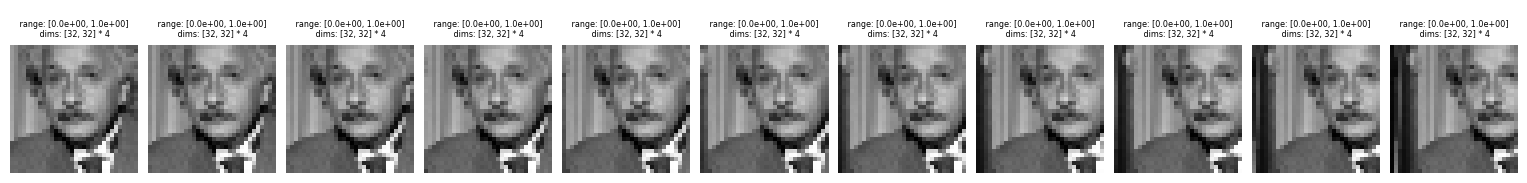

In [12]:
image_size = 64
einstein = po.load_images('../data/256/einstein.pgm')
einstein = po.tools.conv.blur_downsample(einstein, step=(4,4))
vid = po.tools.translation_sequence(einstein[0])
from torchvision.transforms.functional import center_crop
vid = center_crop(vid, image_size // 2)
vid = po.tools.rescale(vid, 0, 1)

imgA = vid[0:1]
imgB = vid[-1:]

pt.image_stats(to_numpy(imgA))
pt.image_stats(to_numpy(imgB))
print(imgA.shape)
print(vid.shape)

# convention: full name for numpy arrays, short hands for torch tensors
video = to_numpy(vid).squeeze()
print(video.shape)
# pt.animshow(video, zoom=4)
pt.imshow(list(video.squeeze()), zoom=4);

In [3]:
import torch.fft
class Fourier(nn.Module):
    def __init__(self, representation = 'amp'):
        super().__init__()
        self.representation = representation
        
    def spectrum(self, x):
        return torch.fft.rfftn(x, dim=(2, 3))

    def forward(self, x):
        if self.representation == 'amp':
            return torch.abs(self.spectrum(x))
        elif self.representation == 'phase':
            return torch.angle(self.spectrum(x))
        elif self.representation == 'rectangular':
            return self.spectrum(x)
        elif self.representation == 'polar':
            return torch.cat((torch.abs(self.spectrum(x)),
                              torch.angle(self.spectrum(x))),
                             dim=1)

# model = Fourier('amp')
model = Fourier('polar') # note: need pytorch>=1.8 to take gradients through torch.angle 

In [15]:
n_steps = len(video)-1
moog = po.synth.Geodesic(imgA, imgB, model, n_steps, init='bridge')
moog.synthesize(max_iter=500, learning_rate=.01, lmbda=.1)

100%|██████████| 500/500 [00:01<00:00, 279.87it/s, loss=1.2985e+03, gradient norm=3.8016e+02, lr=0.01]


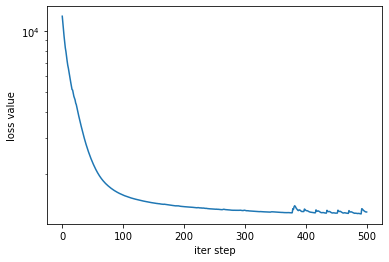

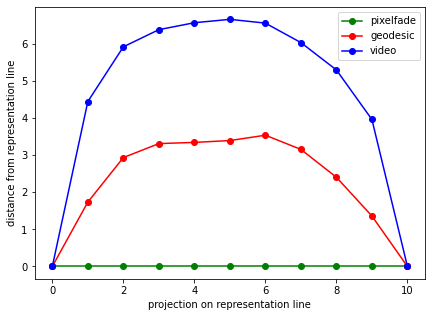

In [16]:
moog.plot_loss();
moog.plot_distance_from_line(vid);

In [6]:
moog.animate_distance_from_line(vid).save("../logs/distfromline_fourierpolar_translation.mp4")

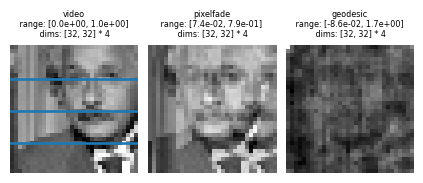

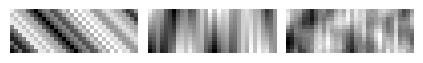

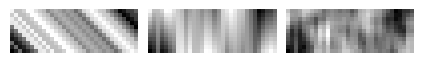

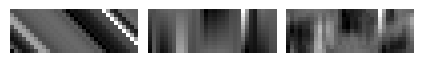

In [7]:
pixelfade = to_numpy(moog.pixelfade.squeeze())
geodesic = to_numpy(moog.geodesic.squeeze())
fig = pt.imshow([video[5], pixelfade[5], geodesic[5]],
          title=['video', 'pixelfade', 'geodesic'],
          col_wrap=3, zoom=4);

size = geodesic.shape[-1]
h, m , l = (size//2 + size//4, size//2, size//2 - size//4)

# for a in fig.get_axes()[0]:
a = fig.get_axes()[0]
for line in (h, m, l):
    a.axhline(line, lw=2)


pt.imshow([video[:,l], pixelfade[:,l], geodesic[:,l]],
          title=None, col_wrap=3, zoom=4);
pt.imshow([video[:,m], pixelfade[:,m], geodesic[:,m]],
          title=None, col_wrap=3, zoom=4);
pt.imshow([video[:,h], pixelfade[:,h], geodesic[:,h]],
          title=None, col_wrap=3, zoom=4);

In [ ]:
geodesic

## Vision models demo¶

/Users/aldebaran/Documents/plenoptic/plenoptic/simulate/canonical_computations/linear_nonlinear.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f1 = torch.tensor(f1, dtype=torch.float32)
/Users/aldebaran/Documents/plenoptic/plenoptic/simulate/canonical_computations/linear_nonlinear.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f2 = torch.tensor(f2, dtype=torch.float32)


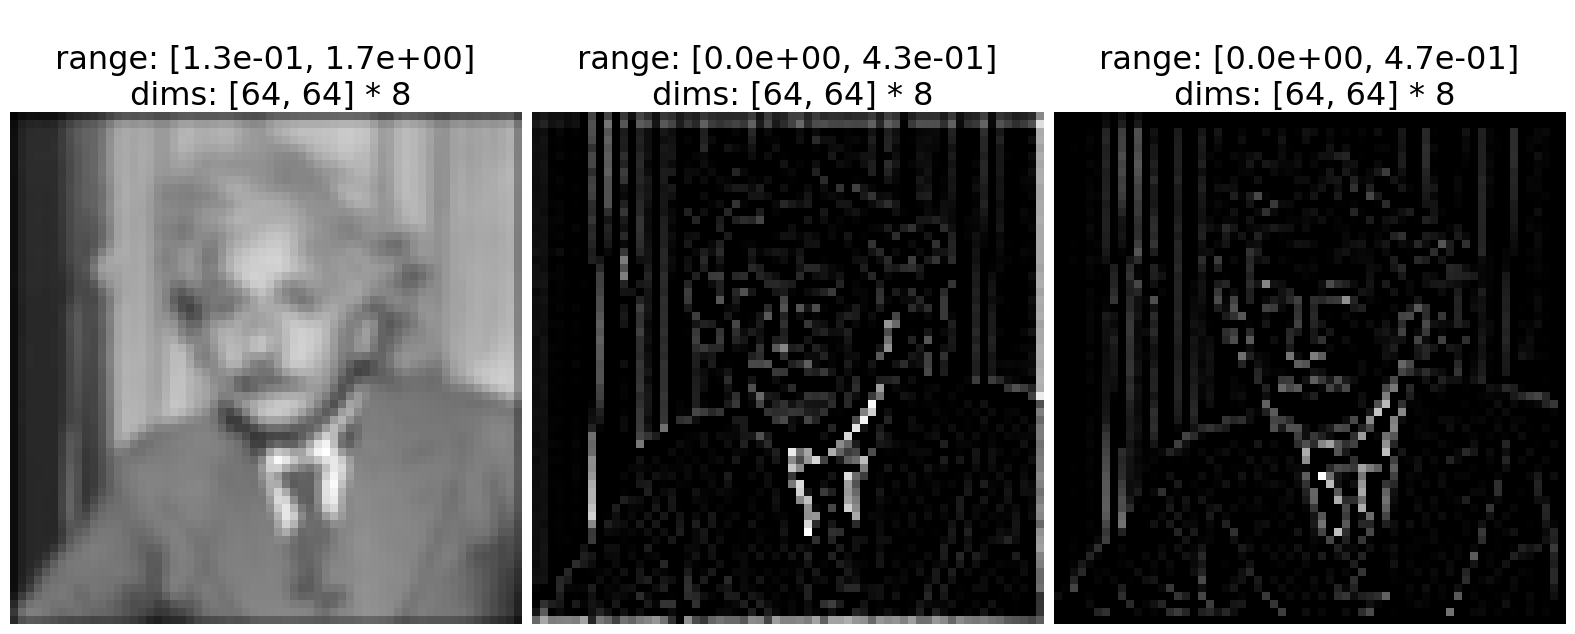

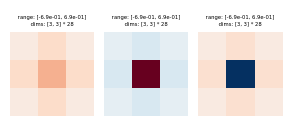

In [42]:
model = po.simul.Linear_Nonlinear()
po.imshow(model(einstein), zoom=8);
po.imshow(model.conv.weight, zoom=28, vrange='auto0');

# TODO
# - speedup front_end -> LGN V1 -> complex
# model = po.simul.Steerable_GainControl(imgB.shape[-2:], is_complex=True,
# n_ori=4, n_scale=5, residuals=False, front_end=True).eval()

# TODO develop hierarchy of texture models 
# model = po.simul.Spectral(image_size=imgB.shape[-2:], n_scale='auto')
# CoupledSpectrum
# PolarPyr

In [ ]:
n_steps = 10

moog = po.synth.Geodesic(imgA, imgB, model, n_steps, init='straight')

print('shape trainable param', '# trainable param')
#  sum(p.numel() for p in moog.parameters())
[p.shape for p in moog.parameters() if p.requires_grad], sum(p.numel() for p in moog.parameters() if p.requires_grad)

In [ ]:
try:
    from adabelief_pytorch import AdaBelief
    optimizer = AdaBelief(moog.parameters(), lr=0.01, eps=1e-16, betas=(0.9,0.999),
                          weight_decouple=True, rectify=False)
except:
    optimizer = torch.optim.RMSprop(moog.parameters(), lr=0.01, alpha=0.99, eps=1e-08,
                                weight_decay=0, momentum=0, centered=False)

moog.synthesize(optimizer=optimizer, lmbda=0.05)

In [13]:
# TODO ideas to deal with unstable optimization: running into NaN
    # gradient clipping
    # control bridge
    # init images
    # logspace 

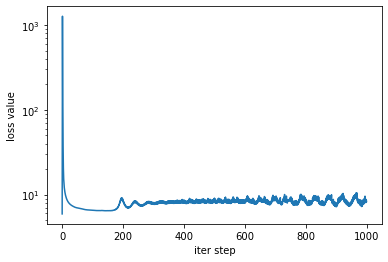

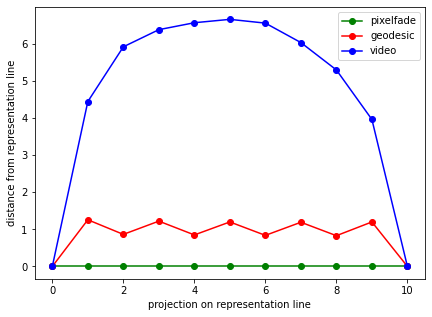

In [14]:
moog.plot_loss()
moog.plot_distance_from_line(vid);

In [17]:
model

NameError: name 'model' is not defined

In [12]:
moog.animate_distance_from_line(vid).save("../logs/distfrom.mp4")

In [13]:
# plt.plot(moog.model(moog.geodesic).view(n_steps+1, -1));

In [14]:
torch.stack(moog.dist_from_line, 0).shape

torch.Size([1001, 11])

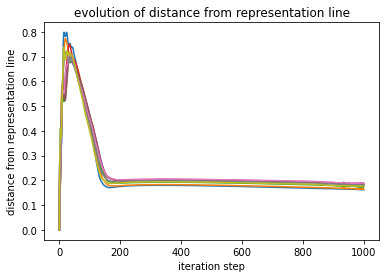

In [15]:
plt.plot(torch.stack(moog.dist_from_line, 0)[:, 1:-1])

plt.title('evolution of distance from representation line')
plt.ylabel('distance from representation line')
plt.xlabel('iteration step')
# plt.yscale('log')
plt.show()

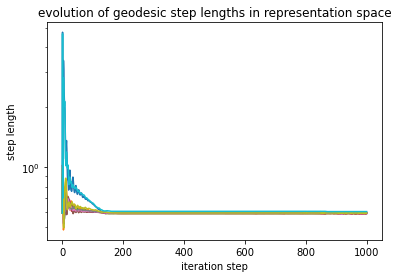

In [16]:
step_lengths = torch.cat(moog.step_energy, dim=0)
# plt.plot(step_lengths[:, 0], 'r--');
plt.plot(step_lengths);
# plt.axhline(po.to_numpy(moog.reference_length / (moog.n_steps - 1)), ls='--', c='k')

plt.xlabel('iteration step')
plt.ylabel('step length')
plt.title('evolution of geodesic step lengths in representation space')

plt.yscale('log')
# plt.ylim([0,2])
# plt.xlim([0,40])
plt.show()

In [17]:
# pt.imshow(list(moog.yA[0]), col_wrap=4);
# pt.imshow(list(moog.yB[0]), col_wrap=4);

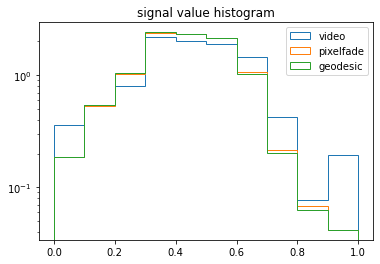

In [18]:
geodesic  = po.to_numpy(moog.geodesic).squeeze()
pixelfade = po.to_numpy(moog.pixelfade).squeeze()
assert geodesic.shape == pixelfade.shape

# checking that the range constraint is met
plt.hist(video.flatten(), histtype='step', density=True, label='video')
plt.hist(pixelfade.flatten(), histtype='step', density=True, label='pixelfade')
plt.hist(geodesic.flatten(), histtype='step', density=True, label='geodesic');
plt.yscale('log')
plt.title('signal value histogram')
plt.legend(loc=1)
plt.show()

geodesic
diff
pixelfade


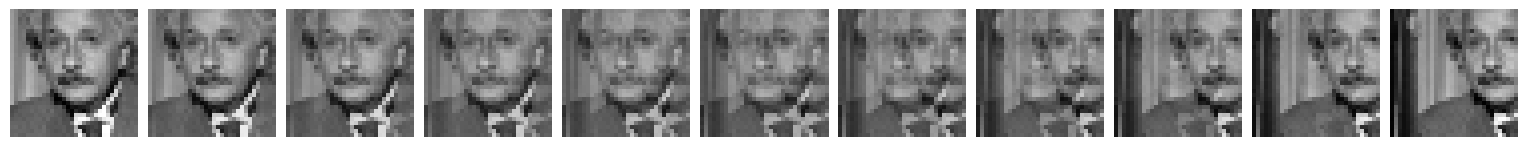

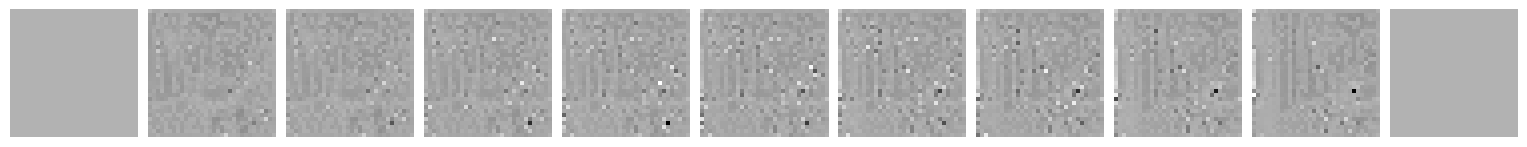

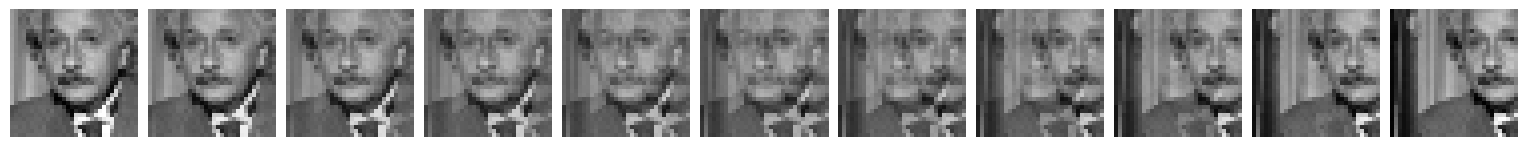

In [19]:
print('geodesic')
pt.imshow(list(geodesic), vrange='auto1', title=None, zoom=4);
print('diff')
pt.imshow(list(geodesic - pixelfade), vrange='auto1', title=None, zoom=4);
print('pixelfade')
pt.imshow(list(pixelfade), vrange='auto1', title=None, zoom=4);

### relative

In [20]:
moog.representational_unit

ModuleAttributeError: 'Geodesic' object has no attribute 'representational_unit'

In [ ]:
plt.plot((moog.step_energy[-1] - moog.representational_unit).squeeze())

In [ ]:
moog.metric(moog.yA - moog.yB) / (moog.n_steps-1)

In [ ]:
moog.metric(moog.pixelfade[1] - moog.pixelfade[0])

In [ ]:
moog.path_energy(moog.geodesic[1:-1], moog.geodesic[0], moog.geodesic[-1])

## Texture interpolation

In [ ]:
path = '../data/256/'
nameA = 'reptil_skin'
nameB = 'metal'

imageA = plt.imread(path + nameA + '.pgm') / 255.
imageB = plt.imread(path + nameB + '.pgm') / 255.

c = 64
imageA = imageA[c:-c, c:-c]
imageB = imageB[c:-c, c:-c]
pt.image_stats(imageA)
pt.image_stats(imageB)

imgSize = imageA.shape[0]
pt.imshow([imageA, (imageA + imageB)/2, imageB], vrange='indep1', zoom=2);

In [ ]:
imgA = torch.tensor(imageA, dtype=dtype).unsqueeze(0).unsqueeze(0)
imgB = torch.tensor(imageB, dtype=dtype).unsqueeze(0).unsqueeze(0)

print(imgA.shape)
from plenoptic.tools.straightness import make_straight_line
n_steps = 11
video = make_straight_line(imgA, imgB, n_steps)
print(video.shape)
pt.image_stats(po.to_numpy(video).squeeze())
pt.animshow(po.to_numpy(video).squeeze(), zoom=2)

## DEV

In [ ]:
def get_angles_dist_accel(x):
    """

    Parameters
    ----------
    x:
    [T C H W]
    
    Returns
    -------
    dist  [T-1]
    theta [T-2]
    accel [T-2 H W]
    
    TODO
    ----
    inverse
    """
    T, C, H, W = x.shape

    x = x.view((T, -1))
    v = x[0:T-1] - x[1:T]
    d = torch.norm(v, dim=1, keepdim=True)
    v_hat = torch.div(v, d)

    theta = torch.empty((T-2))
    accel = torch.empty((T-2, H * W))

    for t in range(T-2):
        theta[t] = torch.acos(v_hat[t] @ v_hat[t+1]) / torch.tensor(np.pi) * 180
        
        accel[t] = v_hat[t] - v_hat[t] @ v_hat[t+1] * v_hat[t]

    accel_hat = torch.div(accel, torch.norm(accel, dim=1, keepdim=True))
    accel_hat = accel_hat.view((T-2, C, H, W))

    return theta, d, accel_hat

In [ ]:
# frontend = po.simul.FrontEnd()
# metamer = po.synth.Metamer(einstein, frontend)
# metamer.synthesize(max_iter=3, store_progress=1)
# metamer.plot_synthesis_status(figsize=(35, 5))
# metamer.animate(figsize=(35, 5))

In [ ]:
x = po.tools.sample_brownian_bridge(imgA, imgB, n_steps)
# x = po.tools.make_straight_line(imgA, imgB, n_steps)
x.shape

In [ ]:
theta, d, a = get_angles_dist_accel(x)

In [ ]:
plt.plot(to_numpy(theta))
plt.ylim((0, 360))
plt.show()
plt.plot(to_numpy(d))
plt.ylim((0, 2))
plt.show()

In [ ]:
pt.imshow(list(to_numpy(x)));

In [ ]:
pt.imshow(list(to_numpy(a)));

In [ ]:
def Haar_1d(x, n_scales=None):
    """
    tool for multiscale geodesic

    in: B 1 T X Y
    Haar decomposition along T axis

    todo:
    work with [T,C,H,W]
    use functionals, to avoid parameters
    """

    if n_scales is None:
        n_scales = int(np.log2(x.shape[-3]))

    diff = nn.Conv3d(1, 1, (2, 1, 1), bias=False)
    blur = nn.Conv3d(1, 1, (2, 1, 1), bias=False, stride=(2, 1, 1))

    diff.weight = nn.Parameter(torch.ones_like(diff.weight))
    diff.weight.select(2, 0).mul_(-1)  # padding = 1 and pop ?
    blur.weight = nn.Parameter(torch.ones_like(diff.weight))

    y = []
    for s in range(n_scales):
        #         print(s, x.shape)
        y.append(diff(x))
        x = blur(x)

    return y


## Cross spectral model

In [ ]:
x = po.make_basic_stimuli(128)
b, c, h, w = x.shape

PP = po.simul.Polar_Pyramid((h, w))
x_hat = PP.synthesis(PP.analysis(x))
assert (x - x_hat).pow(2).mean() < 1e-10

x.shape

In [ ]:
PP = po.simul.Polar_Pyramid((32, 32), n_ori=2)

yA = PP.analysis(imgA)

In [ ]:
pt.imshow(list(yA.squeeze()), zoom=2, col_wrap=6, vrange='indep1');

In [ ]:
(imgA - PP.synthesis(yA)).pow(2).mean()

In [ ]:
zA = PP.analysis(torch.transpose(yA[:, 6:], 1, 0))
pt.imshow(list(zA.view(-1, 32, 32).squeeze()), zoom=2, col_wrap=6);

In [ ]:
torch_flows = [zA[0, 0:2], zA[1, 0:2], zA[2, 2:4], zA[3, 2:4], zA[4, 2:4], zA[5, 2:4]]
flows = []
for f in torch_flows:
    flows.append(po.to_numpy(torch.transpose(f, 2, 0)))

In [ ]:
fig = pt.imshow(list(po.to_numpy(yA[0, 6:])), zoom=10, col_wrap=6, vrange='auto0', title=None);
for ax, flow in zip(fig.axes, flows):
    step = 2
    ax.quiver(np.arange(0, flow.shape[1], step), np.arange(flow.shape[0]-1, -1, -step), 
               flow[::step, ::step, 0], flow[::step, ::step, 1])
plt.show()

fig = pt.imshow(list(po.to_numpy(yA[0, 6:])), zoom=10, col_wrap=6, vrange='auto0', title=None);
for ax, flow in zip(fig.axes, flows):
    step = 2
    flow = flow @ np.array(((0, 1), (-1, 0)))
    ax.quiver(np.arange(0, flow.shape[1], step), np.arange(flow.shape[0]-1, -1, -step), 
               flow[::step, ::step, 0], flow[::step, ::step, 1])
plt.show()

In [ ]:
f = torch_flows[0]

In [ ]:
from einops import reduce

R = torch.tensor(((0, -1), (1, 0)), dtype=torch.float32)


f_rot = torch.einsum('bc , chw -> bhw', R, f)

In [ ]:
pt.imshow(list(f), vrange='auto1', zoom=8);
pt.imshow(list(f_rot), vrange='auto1', zoom=8);

In [ ]:
PP.synthesis()

In [ ]:
zA_modified = zA.clone()
zA_modified[0, 7] = 0

In [ ]:
y_recon = model.synthesis(zA_modified)

In [ ]:
y_recon = torch.transpose(y_recon, 1, 0)

In [ ]:
pt.imshow(list(yA.squeeze()), zoom=2);
pt.imshow(list(y_recon.squeeze()), zoom=2);

In [ ]:
x_recon = model.synthesis(yA)
x_recon.shape

In [ ]:
model

**suggestions from Eero**

- realted decomposition
- field of gradient vector - expansion, 2x2 cov mtx
    - energy, trace
    - orientedness, e0 - e1 / e0 + e1
    - orientation, 
    
no inverting back to coeffs

total gradient energy

In [ ]:
model = po.simul.CrossSpectral(image_size=imgB.shape[-2:], n_scale='auto')

In [ ]:
# imgB = vid[-1:]
imgB = torch.flip(imgB, dims=(2,3))

# with torch.no_grad():
yA = model(imgA)
yB = model(imgB)
# imgA.requires_grad, yA.requires_grad

In [ ]:
model.pyr.num_orientations

In [ ]:
pt.imshow(list(po.to_numpy(model.pyr(imgB)[0, 1:1+6])), zoom=3);
pt.imshow(po.to_numpy(model.pyr(imgB)[0, 1]), zoom=3);
pt.imshow(po.to_numpy(model.pyr(imgB)[0, 6]), zoom=3);
pt.imshow([po.to_numpy(model.pyr(imgB)[0, 6] * model.pyr(imgB)[0, 1]),
           po.to_numpy(model.pyr(imgB)[0, 1] * model.pyr(imgB)[0, 2]),
           po.to_numpy(model.pyr(imgB)[0, 2] * model.pyr(imgB)[0, 3])], zoom=3);

In [ ]:
pt.imshow(list(po.to_numpy(model.pyr(imgB)[0, 2] * model.pyr(imgB)[0, 1])[None,...]), zoom=3);

In [ ]:
pt.imshow(list(po.to_numpy(yB[0])[18:-2]), col_wrap=6, zoom=8, vrange='auto0');

In [ ]:
moog = po.synth.Geodesic(imgA, imgB, model, n_steps, init='straight')

print('shape trainable param', '# trainable param')
#  sum(p.numel() for p in moog.parameters())
[p.shape for p in moog.parameters() if p.requires_grad], sum(p.numel() for p in moog.parameters() if p.requires_grad)